In [9]:
import itertools
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from tqdm import tqdm
import SubpopulationsLib.DataProcessing as dp
import sklearn.metrics as metrics
from sklearn.model_selection import KFold
import scipy as sp
from SubpopulationsLib.Subpopulations import find_theta_sa
from SubpopulationsLib.Subpopulations import mixture_exponentials, mixture_SIR
from SubpopulationsLib.Metrics import MAPE

import warnings
warnings.filterwarnings("ignore")

# function to read data from a csv file
def read_data(filename, start_date, end_date, country):

    # get SIR data from the specified file
    S,I,R = dp.create_SIR_data(country, filename, '../Data/UID_ISO_FIPS_LookUp_Table.csv', start_date, end_date)
    
    # create indices to put data into a weekly format
    indexes_weekly = np.arange(0,S.shape[0],7)

    # use the indices to get weekly data
    S = S[indexes_weekly]
    I = I[indexes_weekly]
    R = R[indexes_weekly]

    # get rid of the first element of the data
    data = I[1:]

    return data


# function to create a plot with a given data set
def plot_data(data, country,title="# of infected people over time in ",x_label="# infected",y_label="time (weeks)"):

    #create a figure
    plt.figure()

    #plot the data
    plt.plot(data)
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    plt.title(title + country)

    return plt

# function to find and return peaks in data
def get_peaks(data,smoothing_alg=sp.signal.savgol_filter,peak_alg=sp.signal.find_peaks):

    # filter used to smooth the data 
    # for more info on filter, look at https://en.wikipedia.org/wiki/Savitzky%E2%80%93Golay_filter
    smoothed_data =  smoothing_alg(data, len(data)//2,3)

    # finds the peaks in the smoothed data
    # uses neighbouring data in dataset to determine local maxima, which are considered peaks
    peaks = peak_alg(smoothed_data)[0]

    return peaks, len(peaks)


def fit_sir_model(data, num_peaks):

    # bounds that are used for the SIR model
    bound_S = (0,1E8)
    bound_beta = (0,1)
    bound_gamma = (0,1)
    bound_coef = (0,1000)
    bound_k = (0,50)
    bound_list_SIR = [bound_S, bound_beta, bound_gamma, bound_coef, bound_k]
 
    return fit_model(data,num_peaks,bound_list_SIR,"SIR")[1]

# function to fit a guassian distribution to the data
def fit_gaussian_model(data, num_peaks):

    # bounds that are used for the Gaussian model
    bounds_mu = (0,50)
    bounds_sigma = (1,6)
    bounds_coef = (0,300000)
    bound_list_Gaussian = [bounds_mu,bounds_sigma,bounds_coef]
    
    return fit_model(data,num_peaks,bound_list_Gaussian,"Gaussian")[1]


# function to fit data to different model types
def fit_model(data,num_mixtures,bound_list=[],model_type="SIR"):

    # get subpopulations in data
    # mixtures, num_mixtures = get_peaks(data)

    # make sure the bound list is not empty
    if len(bound_list) != 0:
        
        # create the list of bounds with repeated values
        # this is faster than nested for loops
        # code used is from https://stackoverflow.com/a/24225372
        bounds = list(itertools.chain.from_iterable(itertools.repeat(i,num_mixtures) for i in bound_list))

    bias = np.min(data)
    norm_I = data - bias

    # check which model will be used
    if model_type == "SIR":
        mixture = mixture_SIR
    elif model_type == "Gaussian":
        mixture = mixture_exponentials

    params = find_theta_sa(bounds,norm_I,mixture)
    y_hat = mixture(params,len(norm_I)) + bias
    return params, y_hat

# function to split the data into k datasets, where 1 subset is heldout, and k-1 are used for training
# this function is not done
def k_folds_cross_val(data,k=10,holdout_index=0):

    # instantiate k folds cross validator object with k=10 folds (from sklearn)
    k_folds = KFold(k)

    # split the data into k datasets
    split_data = k_folds.split(data)

    # return a generator object
    return split_data
    


In [10]:
# turned this into its own function since this may be used often for comparing models
# plots the sir + gaussian models on the same plot
def compare_plots(data,country):

    # make the plot with the original data (not smoothed)
    plot = plot_data(data, country)
    # get the number of peaks in the data
    peaks, num_peaks = get_peaks(data)
    # fit an sir model to the data
    sir = fit_sir_model(data, num_peaks)
    # fit a gaussian model to the data
    gaussian = fit_gaussian_model(data, num_peaks)

    # plot the gaussian, sir, and the peaks on the same plot
    plot.plot(gaussian, color = 'red')
    plot.plot(sir, color = 'green')
    plot.plot(peaks, data[peaks], 'bo')

    plt.legend([
        'Ground truth',
        'Gaussian mix',
        'SIR mix',
    ])
    # show the plot
    plot.savefig('plots/figure1.png')
    mape_mixture_sir = MAPE(data, sir)
    mape_mixture_gaussian = MAPE(data, gaussian)
    print(f'MAPE Gaussian Mix: {mape_mixture_gaussian}\nMAPE Sir Mix: {mape_mixture_sir}\n')
    return

In [11]:
# still working on this
def pred(data, max_k=4):
    min_observ = 5
    # max_k = 4
    results_dict = dict()
    for i in range(max_k):
        results_dict[f'Week {i+1}'] = dict()
        results_dict[f'Week {i+1}']['GT'] = list()
        results_dict[f'Week {i+1}']['Gaussian_mix'] = list()
        results_dict[f'Week {i+1}']['Sir_mix'] = list()

    for i in range(min_observ, data.shape[0]-max_k):
        print(f"Analyzing data up to the observation {i}\n")
        c_data = np.array(data[0:i])
        bias = np.min(c_data)
        norm_I = c_data - bias
        peaks, num_peaks = get_peaks(data)
        # ----------- Mixture of models -----------
        # ---------------------------------
        # Set the parameters for the mixture of signals approach
        # ---------------------------------

        # For the Gaussian model
        bounds_mu = (0,i+6)
        bounds_sigma = (1,6)
        bounds_coef = (0,300000)

        bound_list_Gaussian = [bounds_mu, bounds_sigma, bounds_coef]

        bounds_Gaussian = list()

        for element in bound_list_Gaussian:
            for j in range(num_peaks):
                bounds_Gaussian.append(element)

        # For the SIR model
        bound_S = (0,1E8)
        bound_beta = (0,1)
        bound_gamma = (0,1)
        bound_coef = (0,1000)
        bound_k = (0,i+6)
        bound_list_SIR = [bound_S, bound_beta, bound_gamma, bound_coef, bound_k]

        bounds_SIR = list()

        for element in bound_list_SIR:
            for j in range(num_peaks):
                bounds_SIR.append(element)

        params_gaussian = fit_model(data, num_peaks, bounds_Gaussian, "Gaussian")[0]
        params_sir = fit_model(data, num_peaks, bounds_SIR)[0]
        for k in range(1, max_k+1):
            results_dict[f'Week {k}']['GT'].append(data[i-1+k])
            y_hat_gauss_mix = mixture_exponentials(params_gaussian, len(c_data)+k)+bias
            results_dict[f'Week {k}']['Gaussian_mix'].append(y_hat_gauss_mix[-1])
            y_hat_sir_mix = mixture_SIR(params_sir, len(c_data)+k)+bias
            results_dict[f'Week {k}']['Sir_mix'].append(y_hat_sir_mix[-1])
    return results_dict

In [17]:

def visualize_prediction(results_dict, max_k=4):
    for k in range(1, max_k+1):
        print('Prediction ' + str(k) + ' weeks ahead')
        gt = np.array(results_dict['Week ' + str(k)]['GT'])

        predictions_Gaussian_Mix = np.array(results_dict['Week ' + str(k)]['Gaussian_mix'])
        predictions_SIR_Mix = np.array(results_dict['Week ' + str(k)]['Sir_mix'])

        print('MAPE Gaussian Mix')
        print(MAPE(gt, predictions_Gaussian_Mix))
        print('MAPE SIR Mix')
        print(MAPE(gt, predictions_SIR_Mix))
    
        plt.figure()
        plt.plot(gt)
        plt.plot(predictions_Gaussian_Mix)
        plt.plot(predictions_SIR_Mix)
        plt.legend(['GT', 
                    'Gaussian_mix', 
                    'SIR_mix'])
        plt.savefig(f"plots/week_{k}.png")
    return



MAPE Gaussian Mix: (1.693466855679809, 1.3108034164161833)
MAPE Sir Mix: (2.6456224974315927, 1.8968707834349603)



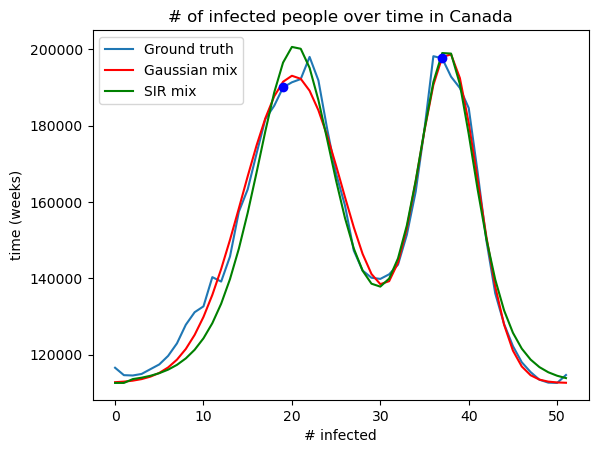

In [13]:
path = "../Data/"
start_date = '7/30/20'
end_date = '7/30/21'
country = 'Canada'

# get the data from folder
data = read_data(path, start_date, end_date, country)

# get the plot
compare_plots(data,country)

In [15]:
pred_results = pred(data)
# print(pred_results)

Analyzing data up to the observation 5

Analyzing data up to the observation 6

Analyzing data up to the observation 7

Analyzing data up to the observation 8

Analyzing data up to the observation 9

Analyzing data up to the observation 10

Analyzing data up to the observation 11

Analyzing data up to the observation 12

Analyzing data up to the observation 13

Analyzing data up to the observation 14

Analyzing data up to the observation 15

Analyzing data up to the observation 16

Analyzing data up to the observation 17

Analyzing data up to the observation 18

Analyzing data up to the observation 19

Analyzing data up to the observation 20

Analyzing data up to the observation 21

Analyzing data up to the observation 22

Analyzing data up to the observation 23

Analyzing data up to the observation 24

Analyzing data up to the observation 25

Analyzing data up to the observation 26

Analyzing data up to the observation 27

Analyzing data up to the observation 28

Analyzing data up to 

Prediction 1 weeks ahead
MAPE Gaussian Mix
(5.58143698336587, 6.710557567125931)
MAPE SIR Mix
(3.3288795120514347, 3.091159973172681)
Prediction 2 weeks ahead
MAPE Gaussian Mix
(6.569147442258641, 7.458718829221016)
MAPE SIR Mix
(3.397666454177138, 3.0700257706030305)
Prediction 3 weeks ahead
MAPE Gaussian Mix
(7.422919665397246, 8.127420061672682)
MAPE SIR Mix
(3.6069787702427902, 2.9013867131926228)
Prediction 4 weeks ahead
MAPE Gaussian Mix
(7.960107828580214, 8.516711381024848)
MAPE SIR Mix
(3.6087792612178853, 3.109754170120973)


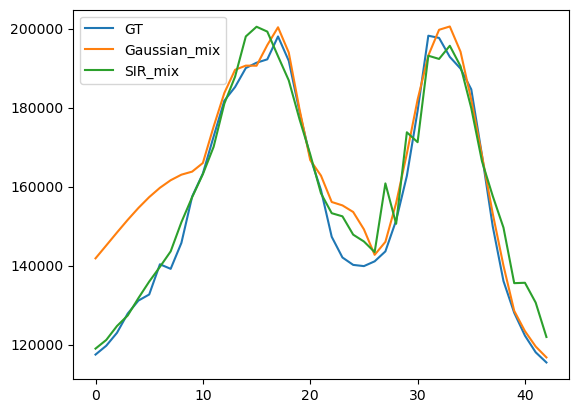

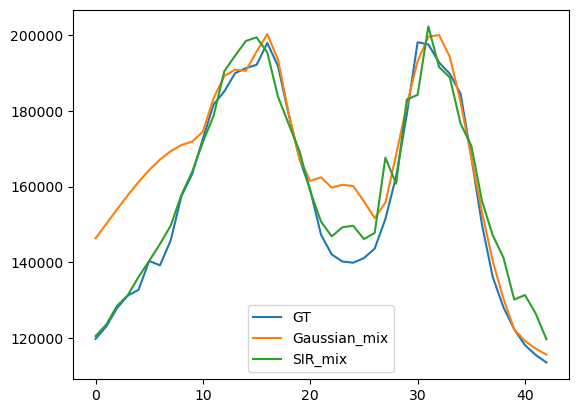

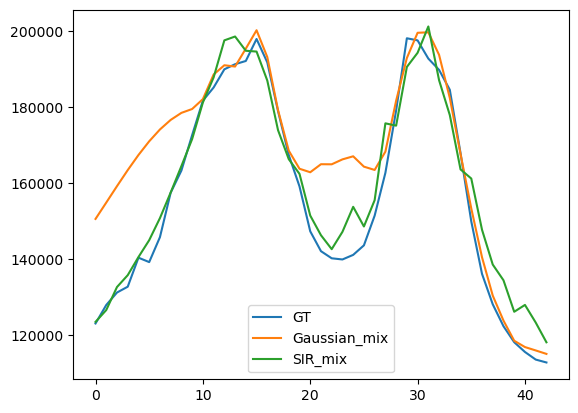

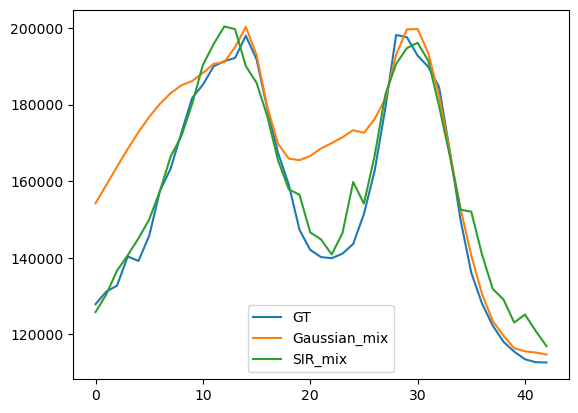

In [18]:
visualize_prediction(pred_results)